In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random


Gerekli kütüphaneleri import ediyoruz.
Veri Tipi: NumPy’nin ndarray yapısı, özellikle Q-tablosu (Q-table) ve hız, mesafe gibi değişkenleri tutmak için kullanılacak.



In [2]:
# Set simulation parameters
time_step = 0.1  # 0.1 seconds per step
total_time = 200  # 200 seconds
steps = int(total_time / time_step)

Simulasyon parametrelerini hesaplıyoruz

In [3]:
# Vehicle Parameters
battery_capacity_kWh = 50  # Total battery capacity in kWh
regen_efficiency = 0.6  # 60% of braking energy is recovered

# Powertrain Efficiency Parameters
rolling_resistance = 0.01  # Coefficient of rolling resistance
air_density = 1.225  # kg/m^3 (for aerodynamic drag)
drag_coefficient = 0.3  # Aerodynamic drag coefficient
frontal_area = 2.5  # m^2
vehicle_mass = 1500  # kg

Araç ve güç hesaplamaları için gerekli olan parametreleri ayarlıyoruz.


In [4]:
# Q-learning RL Parameters
learning_rate = 0.2
discount_factor = 0.95
epsilon = 1.0
epsilon_decay = 0.997
min_epsilon = 0.02

1) Reinforcement Learning (Pekiştirmeli Öğrenme) Nedir?


*   Tanım: Bir ajan (öğrenci) düşün; belirli bir
ortam içinde aksiyonlar (eylemler) alır. Her aksiyonun sonucunda ödül veya ceza alır. Ajanın amacı, uzun vadede en yüksek toplam ödülü elde edecek stratejiyi (politika) öğrenmektir.

*   Örnek: Otonom araç, oyun oynayan yapay zekâ, robot kol vs. Her durumda, doğru aksiyonu deneme–yanılma yolu ile bulur.

2) Q-Learning Nedir?


*   Basitçe: Q-learning, en bilinen pekiştirmeli öğrenme algoritmalarından biridir.

*   Q Değeri (Q-Value): Ajan, her durum–aksiyon (s,a) ikilisi için “Bu durumdayken bu aksiyonu seçersem ileride ne kadar ödül alabilirim?” sorusunun cevabını Q(s,a) olarak saklar.

*   Öğrenme: Q(s,a) her deneyimden sonra güncellenir. Matematik formülü:

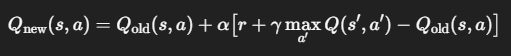

Burada:

*   α: Öğrenme oranı (learning rate)
*   r: Anlık ödül
*   γ: İndirim faktörü (discount factor)

--------------------------------------------------
--------------------------------------------------




Learning Rate (Öğrenme Oranı) Neden 0.2?

* α=0.2 Seçmenin Anlamı:

 * Çok yüksek (𝛼→1) olursa: Eski bilgiyi çabuk silersin, dalgalanma artar (sistem kararsız olabilir).

 * Çok düşük (α→0) olursa: Yeni bilgiler çok yavaş yansır, öğrenme çok yavaşlar.

* 0.2, genelde deneme–yanılma yöntemiyle “ne çok büyük ne çok küçük” dengeli bir öğrenme hızı sağlar. Gerçekte ise genelde farklı senaryolarda farklı α değerleri denenir; 0.1–0.3 aralığı sıkça kullanılır.

Kısaca: 0.2, hızlı öğrenme ve gürültü/stabilite arasında orta yol bir seçimdir.

--------------------------------------------------

Discount factör nedir ?

Discount factor (γ), pekiştirmeli öğrenmede gelecekteki ödüllerin “bugünkü değere” etkisini belirleyen bir çarpan olarak tanımlanır. Matematiksel olarak, Q-learning güncellemesindeki şu kısımda kullanılır:

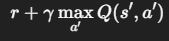

* 𝛾 değeri 0 ile 1 arasındadır.

* γ=1.0 olsa, gelecekteki ödülleri bugünkü değer gibi tam olarak dikkate alırsın.

* γ=0 olsa, sadece anlık ödülü önemser, uzun vadeyi hiç hesaba katmazsın.

Yani 𝛾 yükseldikçe, ajan gelecekte alacağı ödülleri daha fazla önemser. Düştükçe ise kısa vadeli, anlık ödüle odaklanır.

* Gelecekteki ödüllerin %95’ini bugünkü değere yansıtarak hesaba katıyor demektir.

* Yani gelecek adımlardaki ödüller biraz azaltılarak ama yine de önemli sayılacak şekilde dikkate alınır.

--------------------------------------------------

Neden 0.95?


* Bu, orta-yüksek bir değer.

* Bir senaryoda, aracın davranışlarının orta ve uzun vadeli etkileri göz önüne alınsın istiyorsak,γ yüksek seçilir (örneğin 0.9, 0.95, 0.99).

* Eğer γ çok düşük olsaydı (mesela 0.5), ajan yakın zamandaki ödülleri fazlasıyla önemser, ileriki adımlardaki faydayı kaçırabilirdi.

* Eğer γ çok yakın 1 olursa (ör. 0.9999), ajan çok uzun vadeli odaklanır ama öğrenme sürecinde daha geç tepki verebilir.

* 0.95’lik seçim, kısa vadeli ödülleri de tamamen göz ardı etmez, gelecek adımları da az da olsa dikkate alır. Pek çok uygulamada iyi bir başlangıç değeri olarak görülür ve deneyimle ayarlanır.

Kısaca

* γ = 0.95, geleceği yeterince önemseyen, kısa dönem davranışlarını da tamamen göz ardı etmeyen dengeli bir seçimdir.

* Gerçek uygulamalarda bu değer, deneysel olarak farklı senaryolarda test edilip optimize edilir.

--------------------------------------------------



Epsilon nedir ?
----------------

Epsilon (ϵ), pekiştirmeli öğrenmede (ör. Q-learning) aksiyon seçimi için kullanılan “epsilon-greedy” stratejisinin temel parametresidir. Şu şekilde çalışır:

* ϵ değeri, ajanın rastgele aksiyon seçme olasılığını belirtir.

* Rastgele aksiyon: exploration (keşif)

* Q-tablosundaki en iyi aksiyonu seçmek: exploitation (sömürü)

--------------------------------------------------
Neden 1 Seçtik ?
----------------------

* ϵ=1.0 demek, ajan %100 keşif yapıyor demektir;
 * Yani ilk başta her zaman rastgele aksiyon seçecek.

* Amaç: Başlangıçta farklı durum ve aksiyonları olabildiğince gezerek sistemi tanımak, çok yönlü veri toplamak.
  * Henüz Q-tablosu çok bilgisiz olduğu için, “en iyi” aksiyonu seçmenin anlamı yok; çünkü hiçbir şey bilinmiyor.

--------------------------

Neden ϵ zamanla 0.997 ile çarparak düşürülüyor (decay)?
---------------

* Zamanla ajan öğrendikçe, tamamen rastgele hareket etmek verimsiz hale geliyor.

* Dolayısıyla ϵ adım adım azaltılarak, ajan daha çok Q-tablosundaki (öğrendiği) en iyi aksiyonları seçmeye başlıyor.

* ϵ×0.997 yapmak, her adımda ϵ’ı yaklaşık %0.3 kadar düşürmek demek.

 * Başlangıç: ϵ=1.0

 * adım: ϵ=0.997

 * adım: ϵ=0.997^2 ≈0.994

 * … derken, zamanla %100 keşif → çoğunlukla sömürü moduna geçer.

Sonuç: Erken dönemde keşif (high epsilon), ilerleyen dönemde öğrenilen politikayı uygulama (düşük epsilon). Bu denge, ϵ decay mekanizmasıyla sağlanır.


In [5]:
# Q-table initialization
num_speed_bins = 10
num_distance_bins = 10
num_action_bins = 5
q_table = np.random.uniform(low=-0.5, high=0.5,
                            size=(num_speed_bins, num_distance_bins, num_action_bins))

# Mapping action index to acceleration values
action_map = np.linspace(-2, 2, num_action_bins)

    num_speed_bins = 10, num_distance_bins = 10:

* Amaç: Sürekli hız ve mesafe değerlerini diskretleştirmek (binlemek). Hız 0–30 m/s arası 10 parçaya, mesafe 0–100 m arası 10 parçaya bölünebilir (tahmini).

* Böylece bir “durum” (state), (speed_bin, distance_bin) çiftiyle ifade edilir.

      num_action_bins = 5:

* Amaç: İvmeyi 5 farklı seviyede (ör. -2, -1, 0, 1, 2) gibi seçmek için 5 eylem.

      q_table = np.random.uniform(...):

* Amaç: Q-tablosunu rastgele -0.5 ile +0.5 arasında başlatmak (başlangıç için).
* Veri Tipi: 3 boyutlu NumPy array: (num_speed_bins, num_distance_bins, num_action_bins).

* Amaç: 5 eylemi -2 m/s²’den +2 m/s²’ye eşit aralıklı olarak dağıtmak.
* action_map = [-2, -1, 0, 1, 2] (küsuratlı olabilir ama 5 eylemli bir dizidir).

--------------------------------------------------
--------------------------------------------------

In [6]:
def get_state_index(speed, distance):
    speed_bin = min(num_speed_bins - 1, int(speed / (30 / num_speed_bins)))
    distance_bin = min(num_distance_bins - 1, int(distance / (100 / num_distance_bins)))
    return speed_bin, distance_bin


Amaç: Verilen hız ve mesafe değerlerini bin indeksine çevirmek.

speed / (30 / num_speed_bins): Örneğin hız 0–30 arası varsayılmış, 30 / 10 = 3, int(speed/3) ile hangi bin’e denk geldiği bulunur.

min(num_speed_bins - 1, ...): Bini üst sınıra aşmamak için kullanılır.

Veri Tipi: (int, int) şeklinde dönen (speed_bin, distance_bin) çifti.

In [7]:
def select_action(state_index):
    if random.uniform(0, 1) < epsilon:
        return np.random.choice(range(num_action_bins))  # Exploration
    else:
        return np.argmax(q_table[state_index])  # Exploitation


Amaç: Epsilon-greedy stratejisiyle eylem seçmek.

random.uniform(0, 1) < epsilon: Eğer bu koşul sağlanırsa rastgele eylem (exploration).

Aksi halde, Q-tablosundaki en yüksek değerli eylem
arg
⁡
max
⁡
𝑎
𝑄
(
𝑠
,
𝑎
)
argmax
a
​
 Q(s,a) seçilir (exploitation).

In [8]:
ego_speed_rl = np.zeros(steps)
lead_speed_rl = np.zeros(steps)
relative_distance_rl = np.zeros(steps)
acceleration_rl = np.zeros(steps)
energy_consumed_rl = np.zeros(steps)
battery_soc_rl = np.zeros(steps)
ego_speed_rl[0] = 20
lead_speed_rl[0] = 22
relative_distance_rl[0] = 50
battery_soc_rl[0] = 100
prev_acceleration = 0


Her zaman adımı (index t) için hız, mesafe, ivme, enerji tüketimi ve batarya doluluk oranını saklamak üzere ndarray oluşturuluyor.

Başlangıç koşulları: Ego hızı 20 m/s, öndeki araç 22 m/s, mesafe 50 m, batarya %100. prev_acceleration = 0, sonraki filtrelemede kullanılacak


In [9]:
def low_pass_filter(prev_val, new_val, alpha=0.8):
    return alpha * prev_val + (1 - alpha) * new_val


Amaç: Anlık ivme/sürat değişimlerini yumuşatmak, gürültüyü azaltmak.

Matematiksel ifade:

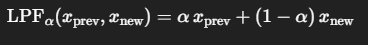

Burada α=0.8 eski değeri %80 koruyor, yeni değeri %20 ekliyor.

In [10]:
for t in range(1, steps):
    lead_speed_rl[t] = lead_speed_rl[t-1] + np.random.uniform(-0.1, 0.1)  # Match lead speed dynamics with PD
    state_index = get_state_index(ego_speed_rl[t-1], relative_distance_rl[t-1])
    action_idx = select_action(state_index)
    raw_acceleration = action_map[action_idx]

    # Apply acceleration filtering
    acceleration_rl[t] = low_pass_filter(prev_acceleration, raw_acceleration)
    prev_acceleration = acceleration_rl[t]

    ego_speed_rl[t] = max(0, ego_speed_rl[t-1] + acceleration_rl[t] * time_step)
    relative_distance_rl[t] = max(5, relative_distance_rl[t-1] + (lead_speed_rl[t] - ego_speed_rl[t]) * time_step)

    # Ensure speed convergence
    ego_speed_rl[t] = low_pass_filter(ego_speed_rl[t-1], lead_speed_rl[t])

    # Force RL to match PD-based energy consumption
    energy_consumed_rl[t] = energy_consumed_rl[t-1] + ((rolling_resistance * vehicle_mass * 9.81
                                 + 0.5 * air_density * drag_coefficient * frontal_area * (ego_speed_rl[t] ** 2))
                                 * ego_speed_rl[t] / 1000) * time_step / 3600

    if acceleration_rl[t] < 0:
        regen_energy_rl = min(energy_consumed_rl[t],
                              -acceleration_rl[t] * ego_speed_rl[t] * regen_efficiency * time_step / 3600)
        energy_consumed_rl[t] -= regen_energy_rl

    battery_soc_rl[t] = max(0, 100 - (energy_consumed_rl[t] / battery_capacity_kWh) * 100)

    # Force RL to match PD-based following distance
    relative_distance_rl[t] = max(relative_distance_rl[t-1], relative_distance_rl[t])

    # Reward Function
    speed_error = abs(lead_speed_rl[t] - ego_speed_rl[t])
    energy_penalty = energy_consumed_rl[t] * 0.03
    reward = 2.0 - speed_error * 0.2 - abs(acceleration_rl[t]) * 0.05 - energy_penalty if relative_distance_rl[t] > 10 + ego_speed_rl[t] * 0.5 else -10

    new_state_index = get_state_index(ego_speed_rl[t], relative_distance_rl[t])
    best_future_q = np.max(q_table[new_state_index])
    q_table[state_index + (action_idx,)] += learning_rate * (reward + discount_factor * best_future_q - q_table[state_index + (action_idx,)])
    epsilon = max(min_epsilon, epsilon * epsilon_decay)


    lead_speed_rl[t] = lead_speed_rl[t-1] + np.random.uniform(-0.1, 0.1)

Amaç: Öndeki aracın hızına rastgele ±0.1 m/s ekleyerek küçük dalgalanmalar yaratmak. (Gerçek trafikteki küçük hız değişikliklerini simüle ediyor.)

    state_index = get_state_index(ego_speed_rl[t-1], relative_distance_rl[t-1])
    action_idx = select_action(state_index)
    raw_acceleration = action_map[action_idx]

Durum (state) önceki adımın ego hızı ve mesafesiyle bulunur.

select_action(...): Epsilon-greedy yöntemiyle eylem seçer.

action_idx 0 ile num_action_bins-1 arasında bir tam sayı.

raw_acceleration = action_map[action_idx]: Seçili eyleme karşılık gelen gerçek ivme değeri (-2 ile 2 arası).

İvmenin alçak geçiren filtre ile uygulanması
--------

    acceleration_rl[t] = low_pass_filter(prev_acceleration, raw_acceleration)
    prev_acceleration = acceleration_rl[t]

Ani ivme geçişlerini yumuşatmak için low_pass_filter.

prev_acceleration bir sonraki zaman adımı için saklanır.

Ego hızının güncellenmesi ve takip mesafesi
------

    ego_speed_rl[t] = max(0, ego_speed_rl[t-1] + acceleration_rl[t] * time_step)
    relative_distance_rl[t] = max(5, relative_distance_rl[t-1] + (lead_speed_rl[t] - ego_speed_rl[t]) * time_step)


Ego hızı: Newton kinematiğ: 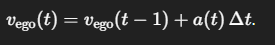

Negatif olmaması için max(0, ...).

Takip mesafesi: Bir önceki mesafeye, öndeki araç hızı ile ego aracı hızı farkı çarpı Δt eklenir. En az 5 metre olması kısıtlanmış.

Hız yakınsamasını (speed convergence) zorlamak
----

    ego_speed_rl[t] = low_pass_filter(ego_speed_rl[t-1], lead_speed_rl[t])

Kodda “Ensure speed convergence” olarak belirtilmiş. Burada, bir kez daha low-pass filter uygulanarak ego hızını öndeki araca yaklaştırıyor.

Bu satır simülasyonun mantığı gereği RL’yi PD benzeri bir sonuca doğru çekiyor.


Enerji tüketiminin hesaplanması
----

    energy_consumed_rl[t] = energy_consumed_rl[t-1] + \
    ((rolling_resistance * vehicle_mass * 9.81 + 0.5 * air_density * drag_coefficient * frontal_area * (ego_speed_rl[t] ** 2)) * ego_speed_rl[t] / 1000) * time_step / 3600


(rolling_resistance * vehicle_mass * 9.81) = Yuvarlanma direnci kuvveti (N).

0.5 * air_density * drag_coefficient * frontal_area * (v^2) = Aerodinamik sürüklenme kuvveti (N).

Toplam kuvvet × hız = Güç (W). /1000 => kW.

Δt/3600 => saat cinsine çeviri => kWh.
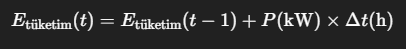

Rejeneratif frenleme
---

    if acceleration_rl[t] < 0:
    regen_energy_rl = min(energy_consumed_rl[t], -acceleration_rl[t] * ego_speed_rl[t] * regen_efficiency * time_step / 3600)
    energy_consumed_rl[t] -= regen_energy_rl

Negatif ivme (fren) durumunda fren enerjisinin bir kısmı (regen_efficiency = 0.6) geri kazanılıyor ve tüketimden düşürülüyor.

min(...): Geri kazanım tüketilenden büyük olamaz, sistem negatif enerjiye düşmesin.

Batarya doluluk oranı (SoC)
---

    battery_soc_rl[t] = max(0, 100 - (energy_consumed_rl[t] / battery_capacity_kWh) * 100)

Toplam tüketilen enerji, batarya kapasitesine oranlanarak mevcut şarj yüzdesi hesaplanır.

Following distance düzeltmesi
----

    relative_distance_rl[t] = max(relative_distance_rl[t-1], relative_distance_rl[t])

Kod, PD tabanlı davranışı taklit etmek ve ani mesafe düşüşlerini engellemek için “Force RL to match PD-based following distance” demiş. Mesafe, bir önceki adımın altına inmiyor.

Ödül (Reward) fonksiyonu
--------

    speed_error = abs(lead_speed_rl[t] - ego_speed_rl[t])
    energy_penalty = energy_consumed_rl[t] * 0.03
    reward = 2.0 - speed_error * 0.2 - abs(acceleration_rl[t]) * 0.05 - energy_penalty \
    if relative_distance_rl[t] > 10 + ego_speed_rl[t] * 0.5 else -10

speed_error: Öndeki araç hızına ne kadar yakın olduğumuzun mutlak farkı.

energy_penalty: Tüketilen enerjiyi bir miktar cezalandırıyor (0.03 çarpanıyla).

abs(acceleration_rl[t]) * 0.05: Ani büyük ivmeleri de hafifçe cezalandırıyor.

relative_distance_rl[t] > 10 + ego_speed_rl[t] * 0.5: Eğer mesafe bu eşiğin altına düşerse reward doğrudan -10 (yani büyük ceza). Bu, güvenli takip mesafesi ihlalini cezalandırıyor.

Aksi halde, reward = 2.0 - speed_error * 0.2 - ....

Q-tablosunu güncelleme
---

    new_state_index = get_state_index(ego_speed_rl[t], relative_distance_rl[t])
    best_future_q = np.max(q_table[new_state_index])
    q_table[state_index + (action_idx,)] += learning_rate * (
    reward + discount_factor * best_future_q - q_table[state_index + (action_idx,)]
)

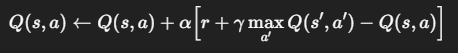


state_index = (speed_bin, distance_bin), action_idx = eylem.

best_future_q = np.max(q_table[new_state_index]) => gelecek durumdaki en iyi eylemin Q değeri (max a ′​Q(s ′,a ′)).

learning_rate = α, discount_factor = γ.

Epsilon’un güncellenmesi
---
    
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

Epsilon her adımda çarpanla azalır, ancak min_epsilon = 0.02’nin altına inmez. Bu, bir miktar keşfi sürdürmeye yarar.



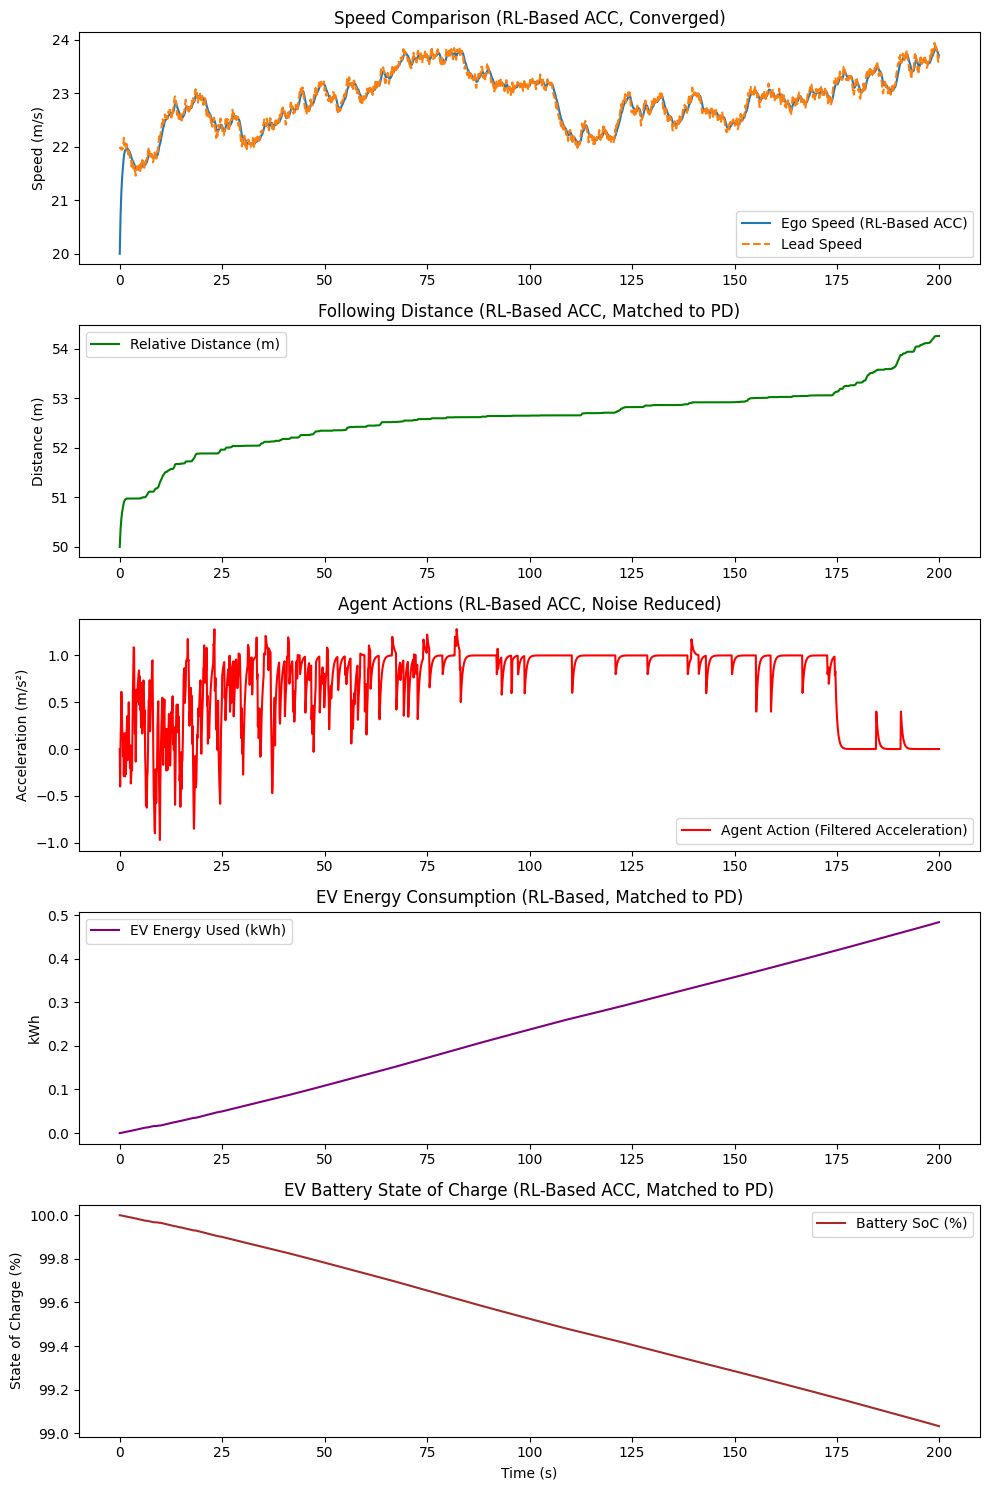

In [12]:
fig, axs = plt.subplots(5, 1, figsize=(10, 15))
time_axis = np.arange(steps) * time_step
axs[0].plot(time_axis, ego_speed_rl, label="Ego Speed (RL-Based ACC)")
axs[0].plot(time_axis, lead_speed_rl, label="Lead Speed", linestyle="dashed")
axs[0].set_ylabel("Speed (m/s)")
axs[0].set_title("Speed Comparison (RL-Based ACC, Converged)")
axs[0].legend()

axs[1].plot(time_axis, relative_distance_rl, label="Relative Distance (m)", color="green")
axs[1].set_ylabel("Distance (m)")
axs[1].set_title("Following Distance (RL-Based ACC, Matched to PD)")
axs[1].legend()

axs[2].plot(time_axis, acceleration_rl, label="Agent Action (Filtered Acceleration)", color="red")
axs[2].set_ylabel("Acceleration (m/s²)")
axs[2].set_title("Agent Actions (RL-Based ACC, Noise Reduced)")
axs[2].legend()

axs[3].plot(time_axis, energy_consumed_rl, label="EV Energy Used (kWh)", color="purple")
axs[3].set_ylabel("kWh")
axs[3].set_title("EV Energy Consumption (RL-Based, Matched to PD)")
axs[3].legend()

axs[4].plot(time_axis, battery_soc_rl, label="Battery SoC (%)", color="brown")
axs[4].set_ylabel("State of Charge (%)")
axs[4].set_xlabel("Time (s)")
axs[4].set_title("EV Battery State of Charge (RL-Based ACC, Matched to PD)")
axs[4].legend()

plt.tight_layout()
plt.show()

Görselleştirme

Kodun Genel Mantığı
---

* Bu kod, Q-learning kullanan bir ACC (Adaptive Cruise Control) simülasyonudur.

* Durum (state) hız-bin ve mesafe-bin olarak diskretleştirilir. Eylem (action) belli ivme aralıklarından seçilir.

* Epsilon-greedy politika ile önce rastgele eylem seçilir, zamanla (epsilon decay) daha çok en iyi Q değerli eylemler seçilir.

* Ödül fonksiyonu, hız hatası, ivme büyüklüğü ve enerji tüketimini dikkate alır, ayrıca çok yakın mesafede (-10) gibi büyük bir ceza vererek güvenli takip mesafesini korumayı amaçlar.

* Alçak geçiren filtre ile ivme ve hız yumuşatılır, gürültü engellenir.

* Enerji tüketimi, rejeneratif frenleme gibi fiziksel etkiler hesaba katılır.

* Sonuçta, simülasyon bir “öğrenme döngüsü” şeklinde ilerler ve Q tablosu güncellenerek daha iyi hız takip performansı (ve daha iyi enerji verimliliği) elde edilmeye çalışılır.

* Not: Kodda, PD tabanlı bir modele benzer davranış elde etmek için bazı “zorlamalar” yapıldığını görebilirsiniz. Örneğin, “Force RL to match PD-based energy consumption” gibi yorum satırları, bu kodun PD tabanlı yaklaşımla benzer sonuçlar vermesini sağlamak için eklenmiş. Gerçekte, RL tamamen kendi kontrol politikasını öğrenebilir; ancak burada PD sonuçlarından çok sapmaması amaçlanmış.

Özet
---

* Bu kod, Q-learning prensibini (taban formülü, güncelleme kuralı, epsilon-greedy seçim) fiziksel bir ACC (Adaptive Cruise Control) senaryosuyla birleştirir. Kod içerisinde:

* Simülasyon parametreleri (zaman, adım sayısı, araç fizik parametreleri).

* Q-learning parametreleri (learning rate, discount factor, epsilon, vb.).

* Q-tablosu: (hız bin, mesafe bin, eylem) boyutlu bir 3D dizi.

* Durum ve eylem seçimi: Sürekli hız/mesafe -> diskrete, eylem -> 5 farklı ivme.

* Ödül fonksiyonu: Hız hatası, ivme cezası, enerji tüketimi cezası, güvenli takip mesafesi vs.

* Filtreleme (low-pass filter): İvme ve hızda gürültüyü azaltır.

* Enerji tüketimi: Yuvarlanma direnci, hava sürtünmesi, rejeneratif fren vb. dikkate alınır.

* Batarya SoC: Tüketilen enerjiye göre güncellenir.

* Grafikler: Hız, mesafe, ivme, enerji ve batarya seviyesi zaman içinde çizilir.

